In [ ]:
#| default_exp aa_mixer_toy

# aa_mixer_toy

> Toy model of the "straightening" of the aa-mixer model

We stick an autoencoder in the middle of some embedding system, designed to preserve linearity in the middle of the autoencoder.

In [ ]:
#| export
from copy import deepcopy
import math
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchaudio
from torch import optim, nn, Tensor
from torch import multiprocessing as mp
from torch.nn import functional as F
from torch.utils import data as torchdata

#from tqdm import tqdm, trange

from tqdm.notebook import trange, tqdm
#from tqdm.auto import tqdm
#import tqdm.notebook as tq
from tqdm.utils import _term_move_up


from einops import rearrange, repeat

import wandb

#from aeiou.viz import embeddings_table, pca_point_cloud, audio_spectrogram_image, tokens_spectrogram_image
#from aeiou.hpc import load, save, HostPrinter, freeze
#from aeiou.datasets import AudioDataset

# audio-diffusion imports
import pytorch_lightning as pl
#from audio_algebra.aa_mixer import * 

NOTE: Redirects are currently not supported in Windows or MacOs.


In [ ]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

device = get_device()
print("device = ",device)
if torch.backends.mps.is_available():
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

device =  mps


## Generic Building Blocks
An activation function, and one map-activation-bn block 

In [ ]:
# cf https://github.com/tyunist/memory_efficient_mish_swish
#|export
class Mish_func(torch.autograd.Function):
    "mish seems to outperform several other activation fns in many ways but YMMV. https://arxiv.org/vc/arxiv/papers/1908/1908.08681v2.pdf"
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0] 
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 
        grad_hx = i.sigmoid()
        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx    
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)

In [ ]:
#| export 
class EmbedBlock(nn.Module):
    def __init__(self, in_dims:int, out_dims:int, act=nn.LeakyReLU(), requires_grad=True, use_bn=False, **kwargs) -> None:
        "generic little block for embedding stuff, doesn't change number of dimensions"
        super().__init__()
        self.bn = nn.BatchNorm1d(out_dims) if use_bn else None
        self.lin = nn.Linear(in_dims, out_dims, **kwargs)
        if requires_grad != True:
            self.lin.weight.requires_grad = requires_grad
            self.lin.bias.requires_grad = requires_grad
        self.act = act

    def forward(self, x: Tensor) -> Tensor:
        x = self.lin(x)
        x = self.act(x)
        if self.bn is not None: x = self.bn(x)   # re. "BN before or after Activation? cf. https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md"
        return x

In [ ]:
# test that
emb_test = EmbedBlock(2, 2, requires_grad=False)

## The Given (Auto)Encoder
This is a stand-in for whatever the main encoder is to be, 
i.e. for which the audio-algebra is going be inserted in the middle of.  
This could be an actual audio encoder or,...just something random.

Now, for word embeddings these are typically just weights from a linear transformation, but we're going to assume that there's maybe some set of nonlinear tranformations that led us to this point. 

We're going to just leave it as some randomly-initialized neural network

In [ ]:
#export   
class GivenAutoEncoder(nn.Module):
    """for now just something random with a bit of nonlinearity
    """
    def __init__(self, 
        in_dims=2,        # number of input dimensions to use
        hidden_dims=32,   # number of hidden dimensions
        emb_dims=2,       # number of output dimensions to use
        frozen_enc=False,   # don't let the encoder weights evolve
        act=nn.LeakyReLU(),  # activation function(s) to use
        ): 
        super().__init__()
        self.encoder = nn.Sequential(  
            #EmbedBlock(in_dims, emb_dims),
            EmbedBlock(in_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
            EmbedBlock(hidden_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
            nn.Linear(hidden_dims, emb_dims)
        )
        self.decoder = nn.Sequential(  
            #EmbedBlock(emb_dims, in_dims),
            EmbedBlock(emb_dims, hidden_dims, act=act),
            EmbedBlock(hidden_dims, hidden_dims, act=act),            
            nn.Linear(hidden_dims, in_dims)
        )
    def forward(self, x):
        emb = self.encoder(x)
        return self.decoder(emb), emb

In [ ]:
# test
test_enc = GivenAutoEncoder()

## Make up some data
For starters, just a bunch of random stuff

In [ ]:
seed = 1
torch.manual_seed(seed)
n_points = 64*10000
in_dims = 2 # number of dimensions the input data will live in, e.g. 2 or 3
emb_dims = 2 # number of dimensions for embeddings 

train_val_split = 0.8 
train_len, val_len = round(n_points*train_val_split), round(n_points*(1-train_val_split))

class RandVecDataset(torch.utils.data.Dataset):
    "very simple dataset"
    def __init__(self, length, dims, device):
        super().__init__()
        self.data = 2*torch.rand(length, dims, device=device) - 1 
        self.data *= 2 
        
    def __getitem__(self, idx):
        return self.data[idx]                                               
        
    def __len__(self): 
         return self.data.shape[0]  
                                                        
train_dataset = RandVecDataset(train_len, in_dims, 'cpu')
val_dataset = RandVecDataset(val_len, in_dims, 'cpu')
v = train_dataset.__getitem__(0)
print(train_dataset.__len__(), v.shape, train_dataset.data.device)
print(val_dataset.__len__(), v.shape, val_dataset.data.device)

512000 torch.Size([2]) cpu
128000 torch.Size([2]) cpu


In [ ]:
batch_size = 128

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Validation demo batch (same each time)

In [ ]:
with torch.no_grad():
    demo_batch = next(iter(val_dl))
    print("demo_batch.shape =",demo_batch.shape)

demo_batch.shape = torch.Size([128, 2])


# (Optional) Train the Given AutoEncoder

In [ ]:
wandb.login()

wandb: Currently logged in as: drscotthawley. Use `wandb login --relogin` to force relogin


True

In [ ]:
torch.manual_seed(seed)
act=torch.nn.GELU() # leakyrelu works fine, give it something else just to be interesting
given_model = GivenAutoEncoder(in_dims=in_dims, act=act, emb_dims=emb_dims).to(device)

Some way to visualize how our model(s) are doing: 

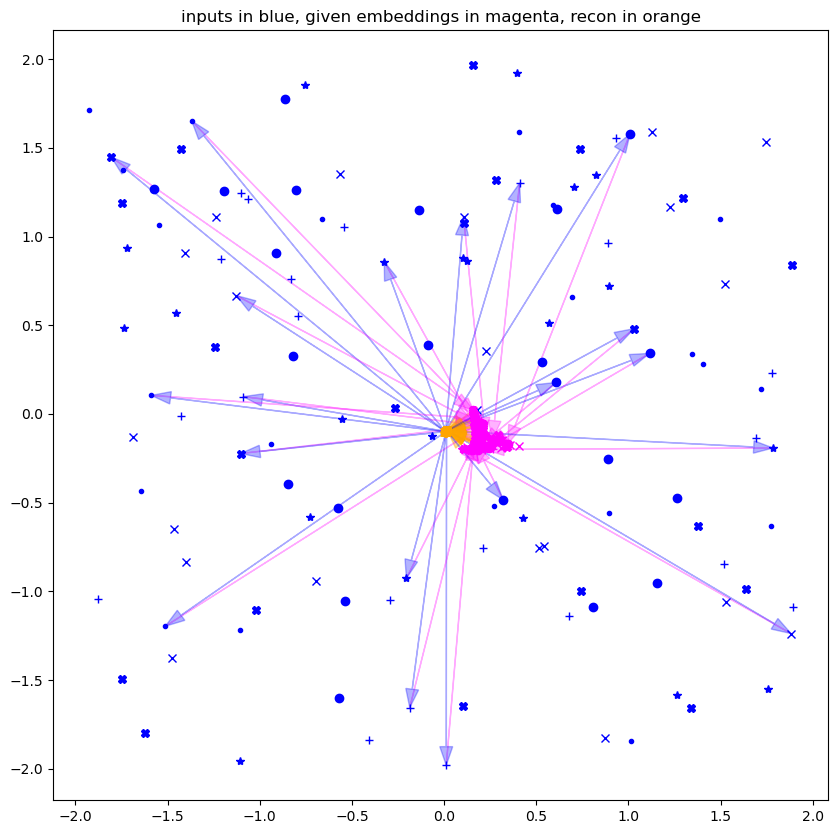

In [ ]:
def viz_batch(
    val_batch,            # should be from val_batch
    given_model,         # the main autoencoder model we are splicing into
    aa_model=None,       # our audio algebra model
    debug=False, 
    device=get_device(),
    return_img = True,
    ):
    markers=['o', '+', 'x', '*', '.', 'X']
    colors=['blue', 'magenta','orange', 'green', 'red']
    n_plot = len(markers)
    val_batch = val_batch.to(device)
    
    with torch.no_grad():
        emb_batch = given_model.encoder(val_batch)
        emb_str = f', emb_batch.shape = {emb_batch.shape}'
        recon_batch = given_model.decoder(emb_batch)

        if aa_model is not None: aa_emb_batch = aa_model.encode(emb_batch)
        
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title(f"inputs in {colors[0]}, given embeddings in {colors[1]}, recon in {colors[2]}")

    for i in range(val_batch.shape[0]):
        mark_i = i % len(markers)  # put markers on the points
        for bi,b in enumerate([val_batch, emb_batch, recon_batch]):
            x, y = b[i][0].cpu().numpy(), b[i][1].cpu().numpy()
            ax.plot(x, y, marker=markers[mark_i], color=colors[bi])
            if bi==1:
                x_emb, y_emb = x,y
            elif bi==0:
                x_in, y_in = x,y
            elif bi==2:
                x_recon, y_recon = x,y
        if i < 20: # draw arrows for some points
            ax.arrow(x_in, y_in, x_emb - x_in, y_emb - y_in, shape='full', alpha=0.3, length_includes_head=True, head_width=0.07, width=0.001, color='magenta')
            ax.arrow(x_emb, y_emb, x_recon - x_emb, y_recon - y_emb, shape='full', alpha=0.4, length_includes_head=True, head_width=0.07, width=0.001, color='orange')
            ax.arrow(x_recon, y_recon, x_in - x_recon, y_in - y_recon, shape='full', alpha=0.3, length_includes_head=True, head_width=0.07, width=0.001, color='blue')

    plt.savefig('val_plot.png', bbox_inches='tight')
    plt.close()
    im = Image.open('val_plot.png')
    return im

viz_batch(demo_batch, given_model)

## (Optional) Training Loop
In the real case we can skip this, but for the toy model we should make sure the given model is a real autoencoder

In [ ]:
def dfs_freeze(model):
    "recursively freeze layers"
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)

In [ ]:
retrain_given_model = True

if retrain_given_model: 
    opt_given = optim.Adam(given_model.parameters(), lr=5e-4)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_given, 'min', factor=0.3, verbose=True)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt_given, max_lr=0.005, total_steps=50000)
    mseloss = nn.MSELoss()

    wandb.finish()
    wandb.init(project='aa-toy')
    epoch, step, max_epochs = 0, 0, 3
    lossinfo_every, demo_every =   20, 500   # in unites of steps
    freeze_enc_at = 2000
    debug = False


    while epoch < max_epochs:  # training loop
        with tqdm(train_dl, unit="batch") as tepoch:
            for batch in tepoch:   # training
                opt_given.zero_grad()

                batch = (2*(2*torch.rand(batch.shape)-1)).to(device) # unending random data!
                out, emb = given_model(batch)
                loss = mseloss(out, batch)
                if step <= freeze_enc_at:
                    loss += 0.001*mseloss(emb, 0*emb)  # wee bit of L2 decay on given embeddings
                wandb.log({'train_loss':loss.detach()})

                if step % lossinfo_every == 0: 
                    tepoch.set_description(f"Epoch {epoch}")
                    tepoch.set_postfix(loss=loss.item())

                if step == freeze_enc_at:  # freeze encoder after this many steps
                    print(f"Step = {step}: Freezing encoder.")
                    for param in given_model.encoder.parameters():
                        param.requires_grad = False
                    given_model.encoder.train(False)
                    given_model.encoder.eval()


                loss.backward()
                opt_given.step() 
                step += 1

                # run on validation set
                with torch.no_grad():
                    val_batch = next(iter(val_dl)).to(device)
                    val_out, emb = given_model(val_batch)
                    val_loss = mseloss(val_out, val_batch)
                    wandb.log({'val_loss':val_loss.detach()})

                    if step % demo_every == 0:
                        im = viz_batch(demo_batch, given_model)
                        wandb.log({"given_mapping": wandb.Image(im),
                                   "outs_hist": wandb.Histogram(out.cpu().detach().numpy()),
                                   "emb_hist": wandb.Histogram(emb.cpu().detach().numpy()),
                                   }) 

            scheduler.step()# val_loss)    

        epoch += 1
        #print("")


  0%|          | 0/4000 [00:00<?, ?batch/s]

Step = 2000: Freezing encoder.


  0%|          | 0/4000 [00:00<?, ?batch/s]

  0%|          | 0/4000 [00:00<?, ?batch/s]

In [ ]:
wandb.finish()

train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,1e-05
val_loss,1e-05


In [ ]:
viz_batch(demo_batch, given_model)

### Save the model

In [ ]:
if retrain_given_model:
    given_path = 'given_model.pth'
    torch.save(given_model.state_dict(), given_path)

### Load the model 

In [ ]:
given_path = 'given_model.pth'
given_model = GivenAutoEncoder(in_dims=in_dims, act=act, emb_dims=emb_dims)
given_model.load_state_dict(torch.load(given_path))
given_model.to(device)
given_model.eval()

GivenAutoEncoder(
  (encoder): Sequential(
    (0): EmbedBlock(
      (lin): Linear(in_features=2, out_features=32, bias=True)
      (act): GELU(approximate='none')
    )
    (1): EmbedBlock(
      (lin): Linear(in_features=32, out_features=32, bias=True)
      (act): GELU(approximate='none')
    )
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): EmbedBlock(
      (lin): Linear(in_features=2, out_features=32, bias=True)
      (act): GELU(approximate='none')
    )
    (1): EmbedBlock(
      (lin): Linear(in_features=32, out_features=32, bias=True)
      (act): GELU(approximate='none')
    )
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

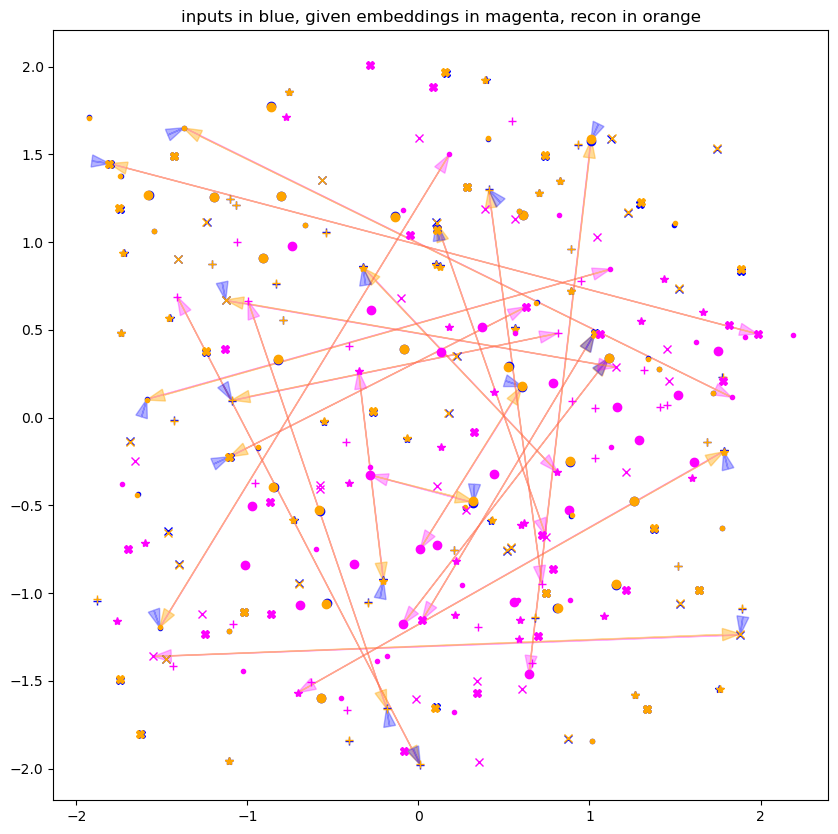

In [ ]:
viz_batch(demo_batch, given_model)

# The AA-mixer model: now our 'Inserted AutoEncoder'
this is the model that we will train

In [ ]:
class AudioAlgebra(nn.Module):
    """
    Main AudioAlgebra model. Contrast to aa-mixer code, keep this one simple & move mixing stuff outside
    """
    def __init__(self, dims=2):
        super().__init__()
        self.given_model = GivenAutoEncoder(in_dims=dims, emb_dims=dims, hidden_dims=64)
    
    def encoder(self,x):
        return  x + self.given_model.encoder(x) # residual connection makes it more stable & helps avoid collapse

    def decoder(self,x):
        return  x - self.given_model.decoder(x)

    def forward(self, 
        x   # the enbedding vector from the given encoder
        ):
        xprime = self.encoder(x)
        xprimeprime = self.decoder(xprime)  # train system to invert itself (and hope it doesn't all collapse to nothing!)
        return xprime, xprimeprime

In [ ]:
test_aa = AudioAlgebra()

### get_stems_faders:
really this is more of a `dataloader` utility but for now its being called from the main loop because it involves less change to the dataloader. ;-) 

In [ ]:
#| export 
def get_stems_faders(batch, dl:torchdata.DataLoader, maxstems=6, debug=False):
    "grab some more inputs and multiplies and some gain values to go with them"
    nstems = 2 + int(torch.randint(maxstems-1,(1,1))[0][0].numpy()) # an int between 1 and maxstems, PyTorch style :-/
    if debug: print("   nstems =",nstems)
    device=batch.device
    faders = 2*torch.rand(nstems)-1  # fader gains can be from -1 to 1
    stems = [batch]                  # note that stems is a list
    dl_iter = iter(dl)
    for i in range(nstems-1):        # in addtion to the stem(s) passed in, grab some more
        next_stem = next(dl_iter).to(device)    # this is just another batch of input data
        if debug: print("  next_stem.shape = ",next_stem.shape)
        stems.append(next_stem)
    return stems, faders.to(device)

Code to to do the encoding of stems and faders into zmix and zsum

* zmix = embedding of the mix (mix = sum of inputs in input space)
* zsum = mix of the embeddings (in embedding space

In [ ]:
def do_mixing(stems, faders, given_model, aa_model, device, debug=False):
    """
    here we actually encode inputs.
    0's denote values in the given model space, non-0's denode those in our aa_model
    e.g., "z0" denotes an embedding from the frozen encoder, "z" denotes re-mapped embeddings

    """
    zs, z0s, zsum, z0sum = [], [], None, None
    mix = torch.zeros_like(stems[0]).to(device)
    #if debug: print("do_mixing: stems, faders =",stems, faders)
    for s, f in zip(stems, faders):   # iterate through list of stems, encode a bunch of stems at different fader settings
        mix_s = (s * f).to(device)                 # audio stem adjusted by gain fader f
        with torch.no_grad():
            z0 = given_model.encoder(mix_s)  # encode the stem
        z = aa_model.encoder(z0)             # <-- this is the main work of the model
        zsum = z if zsum is None else zsum + z # <---- compute the sum of all the z's so far. we'll end up using this in our (metric) loss as "pred"

        mix += mix_s                 # make full mix in input space
        with torch.no_grad():
            z0mix = given_model.encoder(mix)  # encode the mix in the given model
        zmix = aa_model.encoder(z0mix)   #  <----- map that according to our learned re-embedding. this will be the "target" in the metric loss

        # for diagnostics:
        z0sum = z0 if z0sum is None else z0sum + z0   # = sum of embeddings in original model space; we don't really care about z0sum except for diagnostics
        zs.append(z)              # save a list of individual z's
        z0s.append(z0)            # save a list of individual z0's
        
    archive = {'zs':zs, 'mix':mix, 'znegsum':None, 'z0s': z0s, 'z0sum':z0sum, 'z0mix':z0mix} # more info for diagnostics

    return zsum, zmix, archive  # we will try to get these two to be close to each other via loss. archive is for diagnostics

### Instantiate the model

In [ ]:
torch.manual_seed(seed)
aa_model = AudioAlgebra(dims=emb_dims).to(device)
opt = optim.Adam([*aa_model.given_model.encoder.parameters(),*aa_model.given_model.decoder.parameters()], lr=5e-4)  # Adam optimizer
mseloss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.002, total_steps=100000)

In [ ]:
def rel_loss(y_pred: torch.Tensor, y: torch.Tensor) -> float:
    e = torch.abs(y.view_as(y_pred) - y_pred) / torch.abs(y.view_as(y_pred))
    return torch.median(e)

...and visualize its effects

   nstems = 6
  next_stem.shape =  torch.Size([128, 2])
  next_stem.shape =  torch.Size([128, 2])
  next_stem.shape =  torch.Size([128, 2])
  next_stem.shape =  torch.Size([128, 2])
  next_stem.shape =  torch.Size([128, 2])
len(demo_stems) = 6


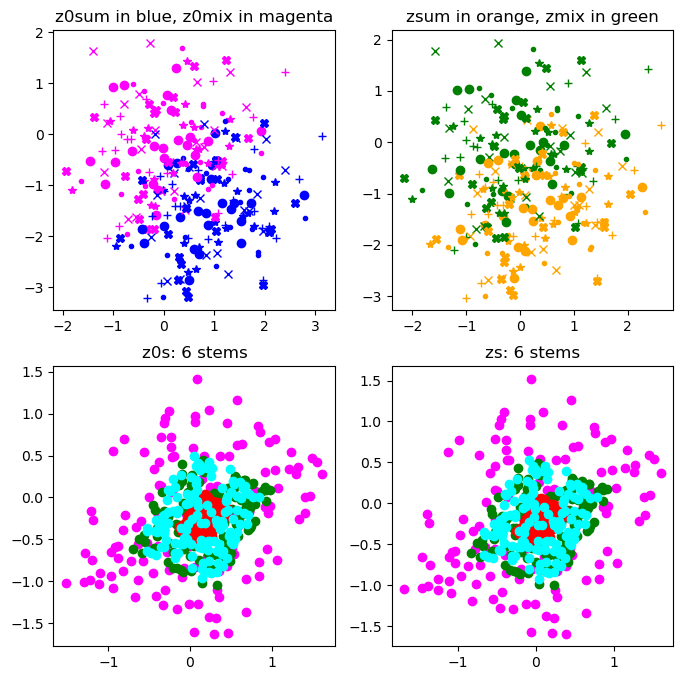

In [ ]:
def viz_aa_batch(
    zsum, zmix,
    archive,
    ):
    "for visualizing what aa model is doing"
    markers=['o', '+', 'x', '*', '.', 'X']
    colors=['blue', 'magenta','orange', 'green', 'red','cyan']
    n_plot = len(markers)
               
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    ax[0,0].set_title(f"z0sum in {colors[0]}, z0mix in {colors[1]}")
    ax[0,1].set_title(f"zsum in {colors[2]}, zmix in {colors[3]}")


    [z0sum, z0mix, zsum, zmix] = [x.detach().cpu().numpy() for x in [archive['z0sum'], archive['z0mix'], zsum, zmix]]
    z0s = [x.detach().cpu().numpy() for x in archive['z0s']]
    zs = [x.detach().cpu().numpy() for x in archive['zs']]
    
    for i in range(zsum.shape[0]):
        mark_i = i % len(markers)  # put markers on the points
        for bi,b in enumerate([z0sum, z0mix, zsum, zmix]):
            x, y = b[i][0], b[i][1]
            ax[0,bi//2].plot(x, y, marker=markers[mark_i], color=colors[bi])

    ax[1,0].set_title(f"z0s: {len(z0s)} stems")
    ax[1,1].set_title(f"zs: {len(zs)} stems")
    #print(f"len(z0s) = {len(z0s)}, z0s[0].shape = {z0s[0].shape}")
    for i in range(len(z0s)):
        x, y = z0s[i][:,0], z0s[i][:,1]
        ax[1,0].plot(x,y,  marker='o', linestyle = 'None', color=colors[i])
        x, y = zs[i][:,0], zs[i][:,1]
        ax[1,1].plot(x,y,  marker='o', linestyle = 'None', color=colors[i])
           
    filename = 'aa_val_plot.png'
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    im = Image.open(filename)
    return im

# test the viz
with torch.no_grad():
    demo_stems, demo_faders = get_stems_faders(demo_batch, val_dl, debug=True)
    print("len(demo_stems) =",len(demo_stems))
    demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=True)
    im = viz_aa_batch(demo_zsum, demo_zmix, demo_archive)
im

In [ ]:
wandb.finish()
wandb.init(project='aa-toy-2')

epoch, step, max_epochs = 0, 0, 2
lossinfo_every, demo_every =   20, 200   # in unites of steps
debug = False
while epoch < max_epochs:  # training loop
    with tqdm(train_dl, unit="batch") as tepoch:
        for batch in tepoch:   # train
            opt.zero_grad()
            batch = (2*(2*torch.rand(batch.shape)-1)).to(device) # unending random data!
            batch = batch.to(device)
            if debug: print(f"--------- step {step}----\n  batch.shape = ",batch.shape) # batch will be one set of input data points
            stems, faders = get_stems_faders(batch, train_dl, debug=debug)
            if debug: print("len(stems), stems[0].shape, faders =",len(stems), stems[0].shape, faders)

            zsum, zmix, archive = do_mixing(stems, faders, given_model, aa_model, device, debug=debug)
            mix_abs_loss = mseloss(zsum, zmix)
            #mix_rel_loss = 2*rel_loss(zsum, zmix)
            mix_loss = mix_abs_loss #+ mix_rel_loss

            '''
            if step==0: 
                var_z0s = torch.stack(archive['z0s'])
                var_z0s = torch.cov( rearrange(var_z0s, 'a b c -> (a b) c').T )
            var_zs = torch.stack(archive['zs']) 
            var_zs = torch.cov( rearrange(var_zs, 'a b c -> (a b) c').T )

            #wandb.log({'var_z0s':var_z0s.detach(), 'var_zs':var_zs.detach()})
            
            var_loss = 1e5*mseloss( var_z0s.flatten(), var_zs.flatten() )
            '''
            
            emb = given_model.encoder(batch)
            aa_enc, aa_dec = aa_model.forward(emb)
            aa_recon_loss = mseloss(emb, aa_dec)
            
            loss = mix_loss + aa_recon_loss #  + var_loss # + aa_recon_loss 
            
            wandb.log({'train_loss':loss.detach(), 'mix_loss':mix_loss.detach(), 'aa_recon_loss':aa_recon_loss.detach()})
 
            if step % lossinfo_every == 0: 
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=loss.item())
            
            loss.backward()
            opt.step()  
            
            # run on validation set
            with torch.no_grad():
                #val_batch = next(iter(val_dl)).to(device)
                #val_stems, val_faders = get_stems_faders(val_batch, val_dl)
                demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=debug)
                val_mix_loss = mseloss(demo_zsum, demo_zmix)
                wandb.log({'val_mix_loss':val_mix_loss.detach()})
                    
                if step % demo_every == 0:
                    im = viz_aa_batch(demo_zsum, demo_zmix, demo_archive)
                    wandb.log({"aa_mapping": wandb.Image(im),
                               }) 
                    
            step += 1
            
        scheduler.step()# val_loss)    
    epoch += 1

  0%|          | 0/4000 [00:00<?, ?batch/s]

  0%|          | 0/4000 [00:00<?, ?batch/s]

  0%|          | 0/4000 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
wandb.finish()